In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [49]:
columns1= inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [39]:
precipitation_query = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
    
for date in precipitation_query:
       recent_date = date.date
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d")

# Calculate the date 1 year ago from today
one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all()



<IPython.core.display.Javascript object>


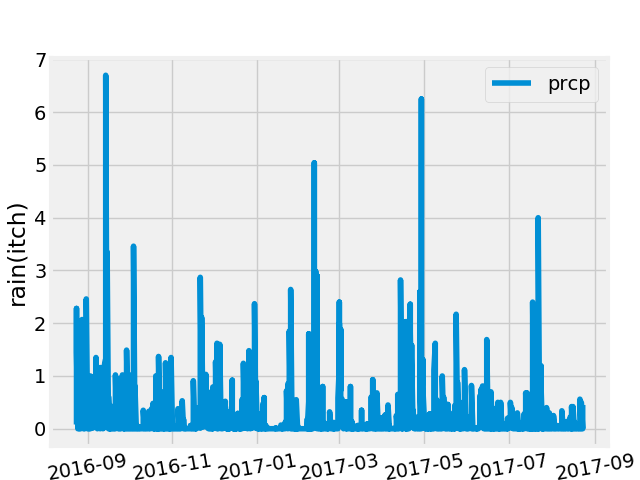

In [44]:

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation_data).dropna()

df['date'] = pd.to_datetime(df['date'])

plt.plot(df['date'], df['prcp'])


plt.xlabel('date')
plt.ylabel('rain(itch)')
plt.xticks(rotation='10')
plt.legend( loc="best")
plt.show()

In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [60]:
# How many stations are available in this dataset?
num_of_stations = session.query(Measurement.station).distinct().count()
num_of_stations


9

In [68]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station ,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [73]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Measurement.station,func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by('count DESC').limit(1)[0][0]

sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station==most_active_station).all()

/Users/ombre0628/anaconda3/lib/python3.6/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


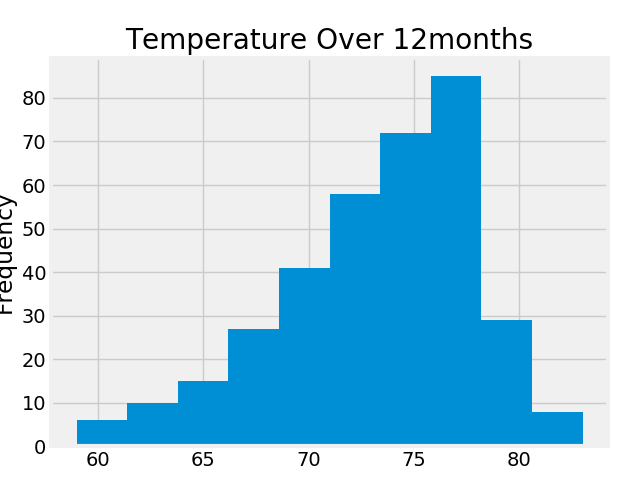

In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(Measurement.tobs).filter(Measurement.station==most_active_station).filter(Measurement.date >= one_year_ago).order_by(Measurement.date.desc()).all()
temp_df= pd.DataFrame(most_active_tobs)

temp_df.hist(bins=10)
plt.title('Temperature Over 12months')
plt.ylabel('Frequency')
plt.show()




In [79]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [80]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2015-02-16', '2015-03-15')
temps

[(56.0, 68.98984771573605, 78.0)]

<IPython.core.display.Javascript object>


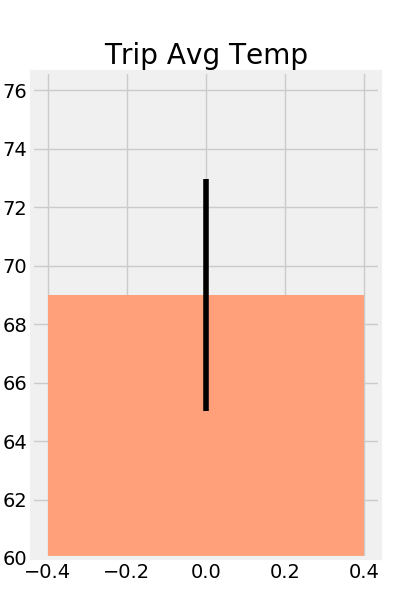

In [94]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(4,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='lightsalmon')

plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim(60)
plt.show()

In [95]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    group_by(Measurement.station).\
    join(Station, Measurement.station==Station.station).\
    order_by(Measurement.prcp.desc()).all()

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.45),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  0.08),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 0.06),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, None)]

## Optional Challenge Assignment

In [96]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


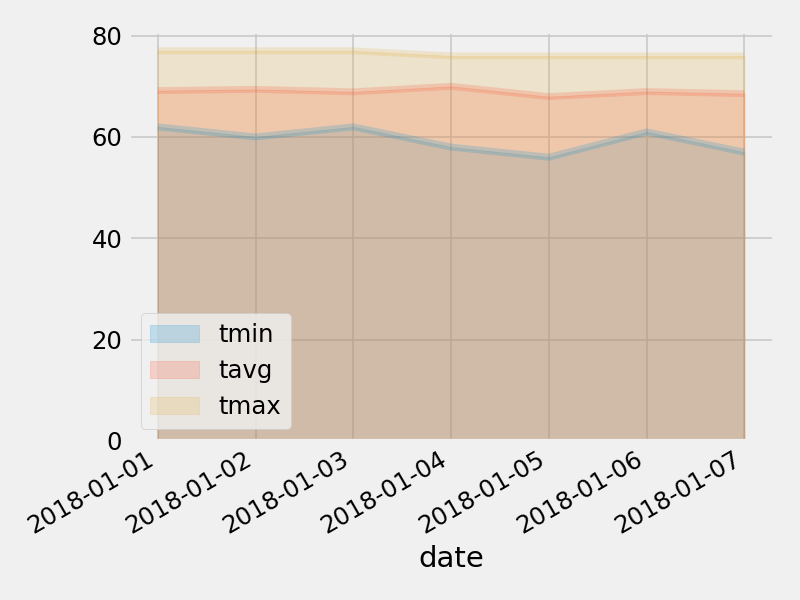

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
